In [1]:
import numpy as np
from bb_exponential import ExponentialBlocks_Events_Alt_2, test_bb_exp
from astropy.stats import bayesian_blocks
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

/nix/store/8qipyzpsb65dlribryvlbmfg9ah5b16x-python3-3.10.13-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Per ottimizzare la scelta di ncp_prior in funzione di N (sum(x)) e p_0 (false detection rate) si procede come da Scargle 2.7:
0) si scelgono degli ncp_prior da testare
1) costruzione di un generatore che mi generi dati provenienti da rumore che in media siano sum=N
2) iterativamente si genera il rumore e si prova il fitting con dei valori di ncp_prior e si salva il numero di blocchi identificati in un array
3) abbiamo così l'array che in posizione i,j ha il numero di blocchi identificati dall'algoritmo con il rumore generato al passo i e con j-esimo ncp_prior
4) per ogni colonna dell'array calcoliamo p_0, ovvero (# casi con più blocchi identificati che 1)/(# casi totali)
5) si sceglie l'ncp_prior più basso (così il metodo è più sensibile) tale che il p_0 associato sia minore del treshold scelto all'inizio (il p_0 di input)

In [3]:
def generator(t,gamma):
    while True:
        x = np.random.poisson(125,len(t))
        idx = np.random.poisson(100)
        y = np.concatenate([np.zeros(idx),np.floor(gamma*np.exp(-np.linspace(0,10,500)))[:500-idx]])
        x=x+y
        yield x

/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:253: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:253: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/nix/store/8qipyzpsb65dlribryvlbmfg9ah5b16x-python3-3.10.13-env/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:467: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)


array([  0. , 100.5, 221.5, 499. ])

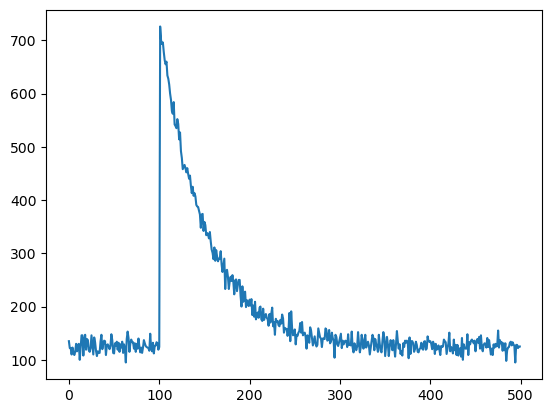

In [4]:
t = np.arange(500)
gen = generator(t,600)
x = next(gen)
plt.plot(x)
bayesian_blocks(t,x,fitness=ExponentialBlocks_Events_Alt_2,ncp_prior=700)

In [5]:
def num_blocks(t,x,ncp_prior_list,fitness):
    arr = np.zeros_like(ncp_prior_list)
    for i in range(len(ncp_prior_list)):
        edg = bayesian_blocks(t,x,fitness=fitness,ncp_prior=ncp_prior_list[i])
        n_edges = len(edg)
        n_blocks = n_edges - 1
        arr[i] = n_blocks
    return arr

In [6]:
def ncp_optimizer(t,gamma,ncp_prior_list,fitness,n_iter=10):
    gen = generator(t,gamma)
    arr = np.zeros((n_iter,len(ncp_prior_list)))
    for i in tqdm(range(n_iter)):
        x = next(gen)
        arr[i] = num_blocks(t,x,ncp_prior_list,fitness)
    arr[arr != 3] = 1
    arr[arr == 3] = 0
    mean_array = np.mean(arr,axis=0)
    return mean_array
    #tmp = np.where(mean_array < p_0)[0]
    #if tmp.size == 0:
    #    return None,mean_array
    #opt_index = tmp[0]
    #return ncp_prior_list[opt_index],mean_array

In [7]:
t=np.arange(500)
gamma=600
ncp_prior_list = np.linspace(1000,1100,2)
#num_blocks(t,x,ncp_prior_list,fitness = ExponentialBlocks_Events_Alt_2)
ncp_optimizer(t,gamma,ncp_prior_list,0.1,fitness = ExponentialBlocks_Events_Alt_2,n_iter=10)

100%|███████████████████████████████████████████| 10/10 [02:19<00:00, 13.90s/it]


(1000.0, array([0., 0.]))

In [7]:
gammas = np.linspace(389.47368421052636,2000,18)
ncp_prior_list = np.linspace(400,1600,20)
t = np.arange(500)
n_iter = 50

#columns = ['gamma'] + ['p_0(ncp='+str(ncp)+')' for ncp in ncp_prior_list] + ['n_iter']
#df = pd.DataFrame(columns = columns)
df = pd.read_csv('ncp.csv')
for gamma in gammas:
    print(f'esecuzione con parametro gamma={gamma}')
    p_0_array = ncp_optimizer(t,gamma,ncp_prior_list,fitness = ExponentialBlocks_Events_Alt_2,n_iter=n_iter)
    df.loc[len(df)] = np.concatenate([np.array([gamma]),p_0_array,np.array([n_iter])])
    df.to_csv('ncp.csv', index = False)

esecuzione con parametro gamma=200.0


  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:253: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:253: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/nix/store/8qipyzpsb65dlribryvlbmfg9ah5b16x-python3-3.10.13-env/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:467: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
100%|████████████████████████████████████████| 50/50 [2:02:01<00:00, 146.44s/it]


esecuzione con parametro gamma=294.7368421052632


  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:253: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:253: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/nix/store/8qipyzpsb65dlribryvlbmfg9ah5b16x-python3-3.10.13-env/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:467: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
100%|████████████████████████████████████████| 50/50 [2:01:54<00:00, 146.29s/it]


esecuzione con parametro gamma=389.47368421052636


  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:253: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:253: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/nix/store/8qipyzpsb65dlribryvlbmfg9ah5b16x-python3-3.10.13-env/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:467: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
  0%|                                                    | 0/50 [00:28<?, ?it/s]


KeyboardInterrupt: 